In [1]:
import numpy as np
import matplotlib.pyplot as plt
import segyio
import os

In [3]:
filename = './data/raw/FullStack_PSTM.segy'

In [4]:
data_cube = segyio.tools.cube(filename)

In [5]:
with segyio.open(filename) as f:
    f.mmap()
    inline_len = len(f.ilines)
    xline_len = len(f.xlines)
    sc = f.attributes(segyio.TraceField.SourceGroupScalar)[0][0]
    sc = np.sqrt(np.square(sc))
    n_samples = f.samples.size
    sr = segyio.tools.dt(f) / 1000
    inline = f.attributes(segyio.TraceField.SourceX)[:] / sc
    xline = f.attributes(segyio.TraceField.SourceY)[:] / sc  
    inline_min = min(inline)
    xline_min = min(xline)
    inline_max = max(inline)
    xline_max = max(xline)
    
    twt = f.samples
    min_twt = min(twt)
    max_twt = max(twt)
          
#inline_len, xline_len = xline_len, inline_len

In [6]:
def read_falt_surface(path):
    plot_arr = []
    grid = []
    grid_space = []
    with open(path) as f:
        while True:
            line = f.readline()
            if not line:
                break
            if 'Grid_size' in line:
                grid_size = list(map(int, line[len('# Grid_size: ') - 1:].split(' x ')))
                grid = np.zeros((grid_size[0], grid_size[1], 3))
            if 'Grid_space' in line:
                grid_space = list(map(float, line[len('# Grid_space: ') - 1:].split(',')))
                grid_space = np.array(grid_space)
            if "#" in line:
                continue
            tmp = list(map(float, line.split(' ')))
            plot_arr.append(tmp[:3])
            grid[int(tmp[3])-1, int(tmp[4])-1] = tmp[:3]
    plot_arr = np.array(plot_arr)
    return plot_arr, grid, grid_space

In [7]:
fault_dirs = ["data/raw/faults/"]

all_faults_grid = []
for fault_dir in fault_dirs:
    files = os.listdir(fault_dir)
    for file in files:
        points, grid, space  = read_falt_surface(fault_dir + file)
        all_faults_grid.append(grid)

In [9]:
len(all_faults_grid)

53

In [10]:
def get_trgls(fault_grid, x_scale=1, y_scale=1, z_scale=1):
    a, b, _ = fault_grid.shape
    trgls = []
    null_point = [0, 0, 0]
    for i in range(b - 1): # hor line
        for j in range(a - 1): # ver line
            for mod2 in range(2):
                if mod2 % 2 == 0:
                    p1 = fault_grid[j, i]
                    p2 = fault_grid[j, i + 1]
                    p3 = fault_grid[j + 1, i]
                else:
                    p1 = fault_grid[j+1, i]
                    p2 = fault_grid[j, i + 1]
                    p3 = fault_grid[j + 1, i + 1]
                if (null_point == p1).all() or (null_point == p2).all() or\
                (null_point == p3).all():
                    continue
                else:
                    trgls.append([p1, p2, p3])
    trgls = np.array(trgls)
    trgls[:, :, 0] = x_scale * trgls[:, :, 0]
    trgls[:, :, 1] = y_scale * trgls[:, :, 1]
    trgls[:, :, 2] = z_scale * trgls[:, :, 2]
    return np.array(trgls)

In [11]:
def get_slice_points(num, view):
    with segyio.open(filename) as f:
        inline_len = len(f.ilines)
        xline_len = len(f.xlines)
        #inline_len, xline_len = xline_len, inline_len
        sc = f.attributes(segyio.TraceField.SourceGroupScalar)[0][0]
        sc = np.sqrt(np.square(sc))
        
        if view == 'inline':
            p1 = (f.attributes(segyio.TraceField.SourceX)[xline_len * num][0] / sc,
                  f.attributes(segyio.TraceField.SourceY)[xline_len * num][0] / sc, 0) 
            p2 = (f.attributes(segyio.TraceField.SourceX)[xline_len * (num + 1) - 1][0] / sc,
                  f.attributes(segyio.TraceField.SourceY)[xline_len * (num + 1) - 1][0] / sc, 0)
            p3 = (f.attributes(segyio.TraceField.SourceX)[xline_len * num][0] / sc,
                  f.attributes(segyio.TraceField.SourceY)[xline_len * num][0] / sc, 100)
        elif view == 'xline':
            p1 = (f.attributes(segyio.TraceField.SourceX)[num][0] / sc,
                  f.attributes(segyio.TraceField.SourceY)[num][0] / sc, 0)
            p2 = (f.attributes(segyio.TraceField.SourceX)[num + xline_len*(inline_len - 1)][0] / sc,
                  f.attributes(segyio.TraceField.SourceY)[num + xline_len*(inline_len - 1)][0] / sc, 0)
            p3 = (f.attributes(segyio.TraceField.SourceX)[num][0] / sc,
                  f.attributes(segyio.TraceField.SourceY)[num][0] / sc, 100)
            
        elif view == 'map':
            p1 = (0, 0, num)
            p2 = (xline_len, inline_len, num)
            p3 = (1, 0, num)
            
    return p1, p2, p3

In [12]:
get_slice_points(45, 'xline')

((110347.0, 1131474.0, 0),
 (121787.0, 1142910.0, 0),
 (110347.0, 1131474.0, 100))

In [13]:
def plane_equation(p1, p2, p3):
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    x3, y3, z3 = p3
    
    vector1 = [x2 - x1, y2 - y1, z2 - z1]
    vector2 = [x3 - x1, y3 - y1, z3 - z1]

    cross_product = [vector1[1] * vector2[2] - vector1[2] * vector2[1],
                     -1 * (vector1[0] * vector2[2] - vector1[2] * vector2[0]),
                     vector1[0] * vector2[1] - vector1[1] * vector2[0]]

    a = cross_product[0]
    b = cross_product[1]
    c = cross_product[2]
    d = - (cross_product[0] * x1 + cross_product[1] * y1 + cross_product[2] * z1)
    return a, b, c, d

In [14]:
# generic math functions

def add_v3v3(v0, v1):
    return (
        v0[0] + v1[0],
        v0[1] + v1[1],
        v0[2] + v1[2],
    )


def sub_v3v3(v0, v1):
    return (
        v0[0] - v1[0],
        v0[1] - v1[1],
        v0[2] - v1[2],
    )


def dot_v3v3(v0, v1):
    return (
        (v0[0] * v1[0]) +
        (v0[1] * v1[1]) +
        (v0[2] * v1[2])
    )


def len_squared_v3(v0):
    return dot_v3v3(v0, v0)


def mul_v3_fl(v0, f):
    return (
        v0[0] * f,
        v0[1] * f,
        v0[2] * f,
    )

In [15]:
def isect_line_plane_v3_4d(p0, p1, plane, epsilon=1e-16):
    u = sub_v3v3(p1, p0)
    dot = dot_v3v3(plane, u)

    if abs(dot) > 0:
        # Calculate a point on the plane
        # (divide can be omitted for unit hessian-normal form).
        p_co = mul_v3_fl(plane, -plane[3] / len_squared_v3(plane))

        w = sub_v3v3(p0, p_co)
        fac = -dot_v3v3(plane, w) / dot
        u = mul_v3_fl(u, fac)
        return add_v3v3(p0, u)

    return None

In [16]:
def check_if_point_on_line(p1, p2, p, eps=1e-5):
    x1, y1, _ = p1
    x2, y2, _ = p2
    x, y = p
    res = ((x - x1)*(y2 - y1) - (y - y1)*(x2 - x1)) < eps
    return res

In [17]:
def check_if_inside_segment(p1, p2, p,):
    x1, y1, _ = p1
    x2, y2, _ = p2
    x, y, _ = p
    x_min = min(x1, x2)
    x_max = max(x1, x2)
    y_min = min(y1, y2)
    y_max = max(y1, y2)
    res = (x_min <= x <= x_max) and (y_min <= y <= y_max)
    return res

In [18]:
def add_point(p, m):
    x, y = p
    if 0 < x < m.shape[0] and 0 < y < m.shape[1]:
        m[x, y] = 1
    else:
        pass

def get_line(start, end, m):
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1

    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)

    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2

    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True

    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1

    # Calculate error
    error = int(dx / 2)
    ystep = 1 if y1 < y2 else -1

    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)
        add_point(coord, m)
        #points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx

    # Reverse the list if the coordinates were swapped
    #if swapped:
    #    points.reverse()
    #return points

In [19]:
def find_closest(A, target):
    #A must be sorted
    idx = A.searchsorted(target)
    idx = np.clip(idx, 1, len(A)-1)
    left = A[idx-1]
    right = A[idx]
    idx -= target - left < right - target
    return idx

In [20]:
def get_slice_section(num, view, trgls, res, _inl, _xl):
    pl = np.array(get_slice_points(num, view))
    pl_eq = plane_equation(*pl)
    
    #if view == 'inline':
    inl = _inl[xline_len * num : xline_len * (num + 1) - 1]

    #elif view == 'xline':
    xl = _xl[num : num + xline_len*(inline_len - 1) : (xline_len)]
    #print(xl[:50])         
    for i, t in enumerate(trgls):
        p = []
        points = t
        sec_1 = isect_line_plane_v3_4d(points[0], points[1], pl_eq)
        
        if sec_1:
            if check_if_inside_segment(points[0], points[1], sec_1):
                p.append(sec_1)

        sec_2 = isect_line_plane_v3_4d(points[1], points[2], pl_eq)
        if sec_2:
            if check_if_inside_segment(points[1], points[2], sec_2):
                p.append(sec_2)

        sec_3 = isect_line_plane_v3_4d(points[2], points[0], pl_eq)
        if sec_3:
            if check_if_inside_segment(points[2], points[0], sec_3):
                p.append(sec_3)    

        if len(p) == 2:
            if view == 'inline':
                a1 = find_closest(inl, p[0][0])
                a2 = find_closest(inl, p[1][0]) 
                b1 = int(round((p[0][2] - min_twt)/sr))
                b2 = int(round((p[1][2] - min_twt)/sr))
                start = [a1, b1]
                end = [a2, b2]
                get_line(start, end, res)
                add_point(start, res)
                add_point(end, res)
                
            elif view == 'xline':
                a1 = find_closest(xl, p[0][1])
                a2 = find_closest(xl, p[1][1]) 
                b1 = int(round((p[0][2] - min_twt)/sr))
                b2 = int(round((p[1][2] - min_twt)/sr))
                #print(a1, a2, b1, b2)
                start = [a1, b1]
                end = [a2, b2]
                get_line(start, end, res)
                add_point(start, res)
                add_point(end, res)

In [21]:
xline_len, inline_len, n_samples

(914, 648, 1801)

In [22]:
def get_slice(faults, num, view, x_scale=1, y_scale=1, z_scale=1):
    if view == 'inline':
        res = np.zeros([xline_len, n_samples])
    elif view == 'xline':
        res = np.zeros([inline_len, n_samples])
    elif view == 'map':
        res = np.zeros([inline_len, xline_len])
        
    with segyio.open(filename) as f:
        f.mmap()
        
        
    for i, f in enumerate(faults):
        trgls = get_trgls(f, z_scale=z_scale)
        
        get_slice_section(num, view, trgls, res, inline, xline)
    return res

In [32]:
num = 300
view = 'inline'

In [33]:
res = get_slice(all_faults_grid,  num, view, z_scale=-1)
if view == 'inline':
    cube = data_cube[num]
elif view == 'xline':
    cube = data_cube[:, num]

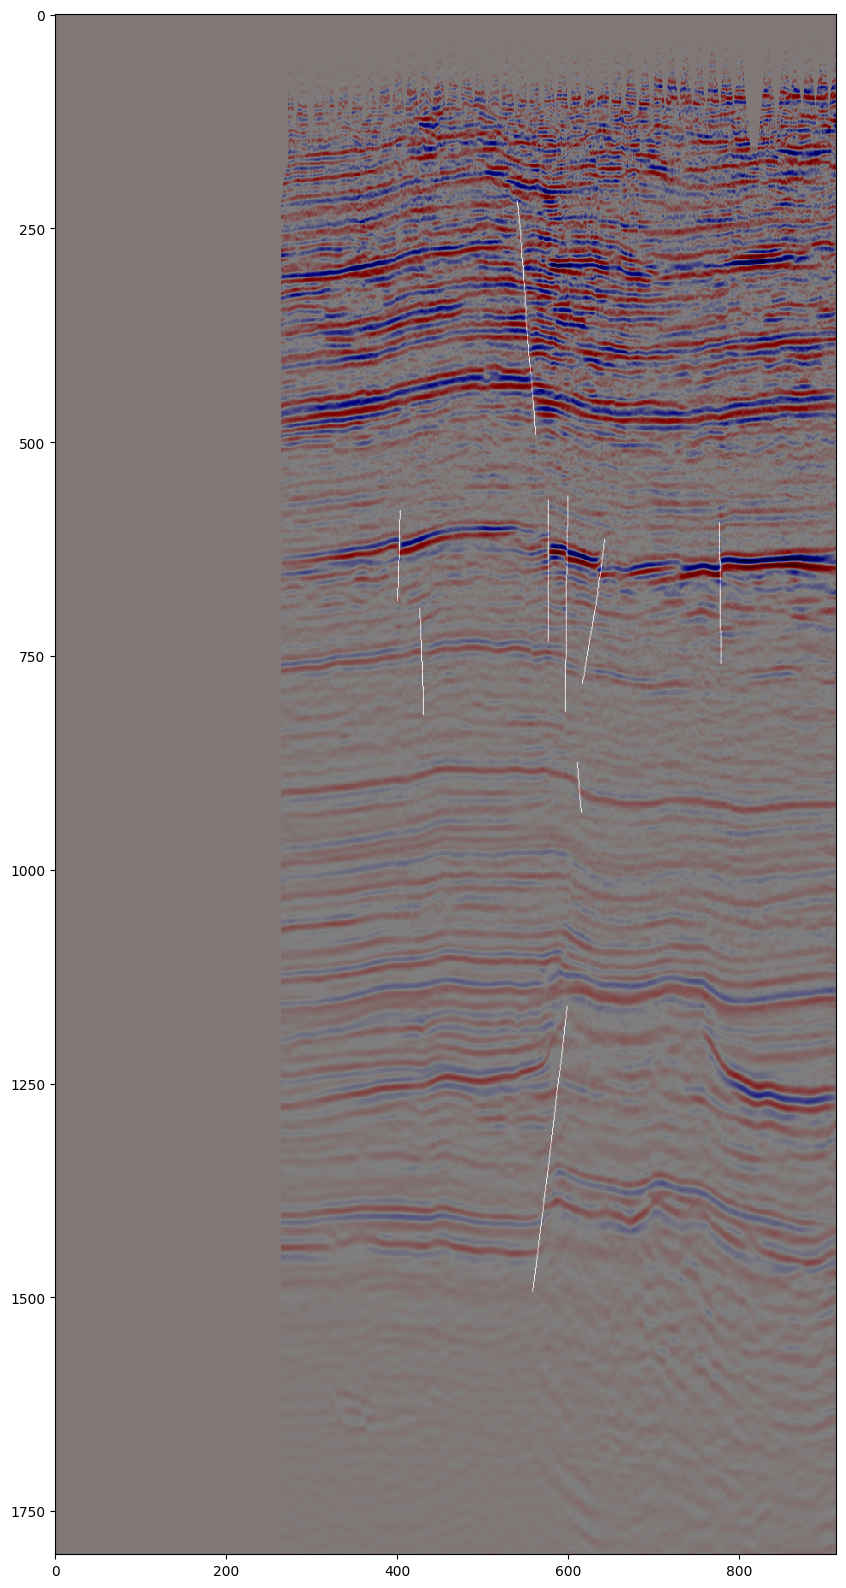

In [34]:
plt.figure(figsize=(20,20))
plt.imshow(cube.T, interpolation='nearest', cmap='seismic')
plt.imshow(res.T,  cmap='gray', alpha=0.5)

In [45]:
seismic_inlines = []
fault_inlines = []
view = 'inline'
for num in range(inline_len):
    res = get_slice(all_faults_grid,  num, view, z_scale=-1)
    if view == 'inline':
        cube = data_cube[num]
    elif view == 'xline':
        cube = data_cube[:, num]
    seismic_inlines.append(cube.T)
    fault_inlines.append(res.T)
seismic_inlines = np.array(seismic_inlines)
fault_inlines = np.array(fault_inlines)

In [62]:
np.savez_compressed('data/raw/numpy/inline_data', seismic_inlines)
np.savez_compressed('data/raw/numpy/inline_faults', fault_inlines)

In [2]:
seismic_inlines = np.load('data/raw/numpy/inline_data.npz')['arr_0']
fault_inlines = np.load('data/raw/numpy/inline_faults_thick_7.npz')['arr_0']

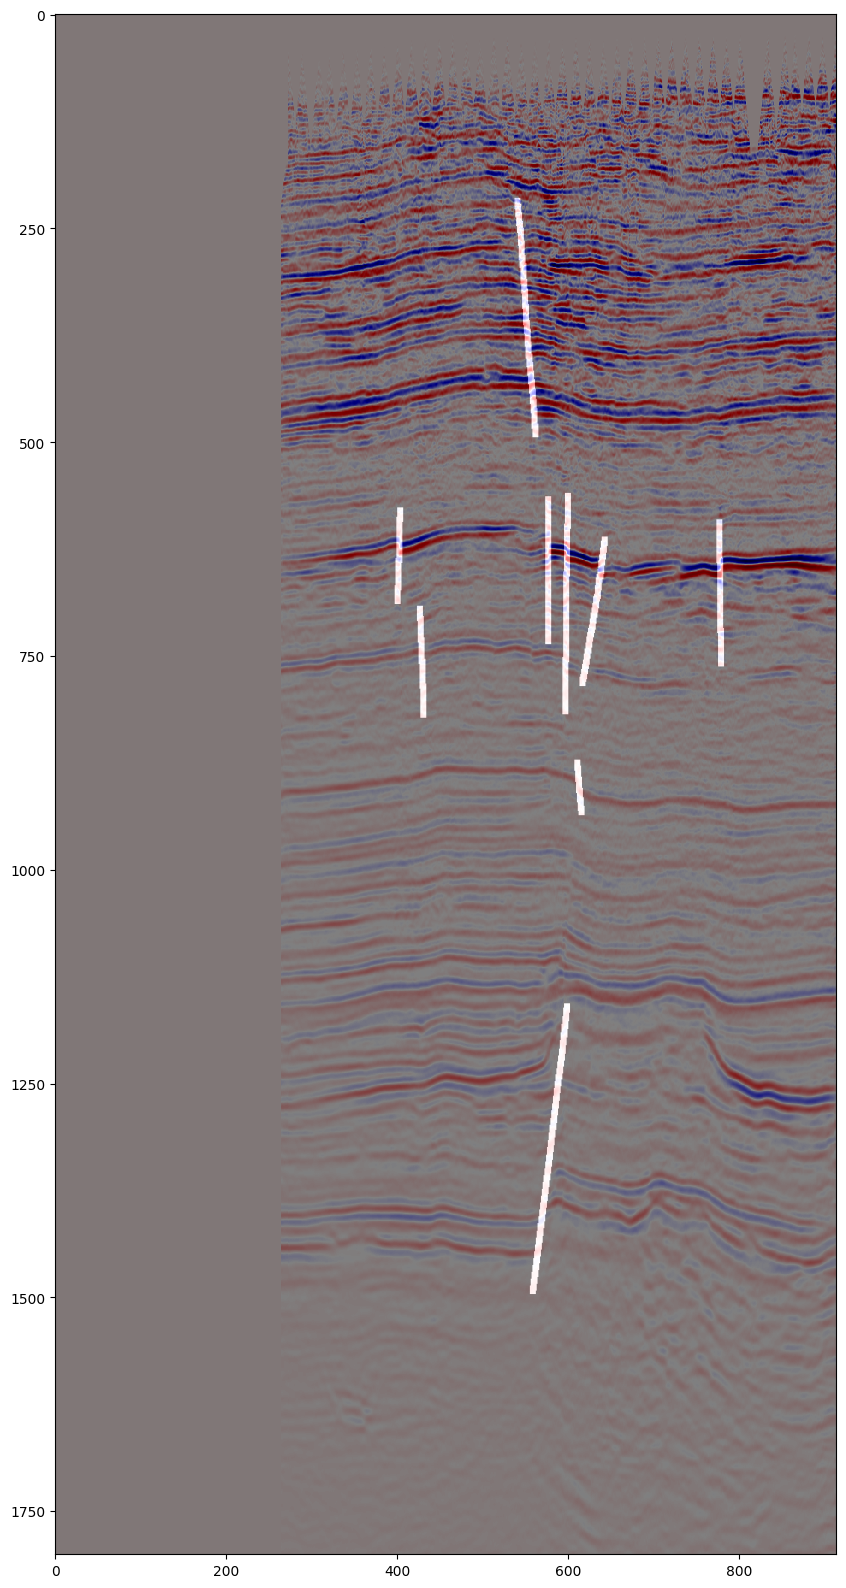

In [3]:
slice_num = 300
cube_slice = seismic_inlines[slice_num]
fault_slice = fault_inlines[slice_num]
plt.figure(figsize=(20,20))
plt.imshow(cube_slice, interpolation='nearest', cmap='seismic')
plt.imshow(fault_slice,  cmap='gray', alpha=0.5)

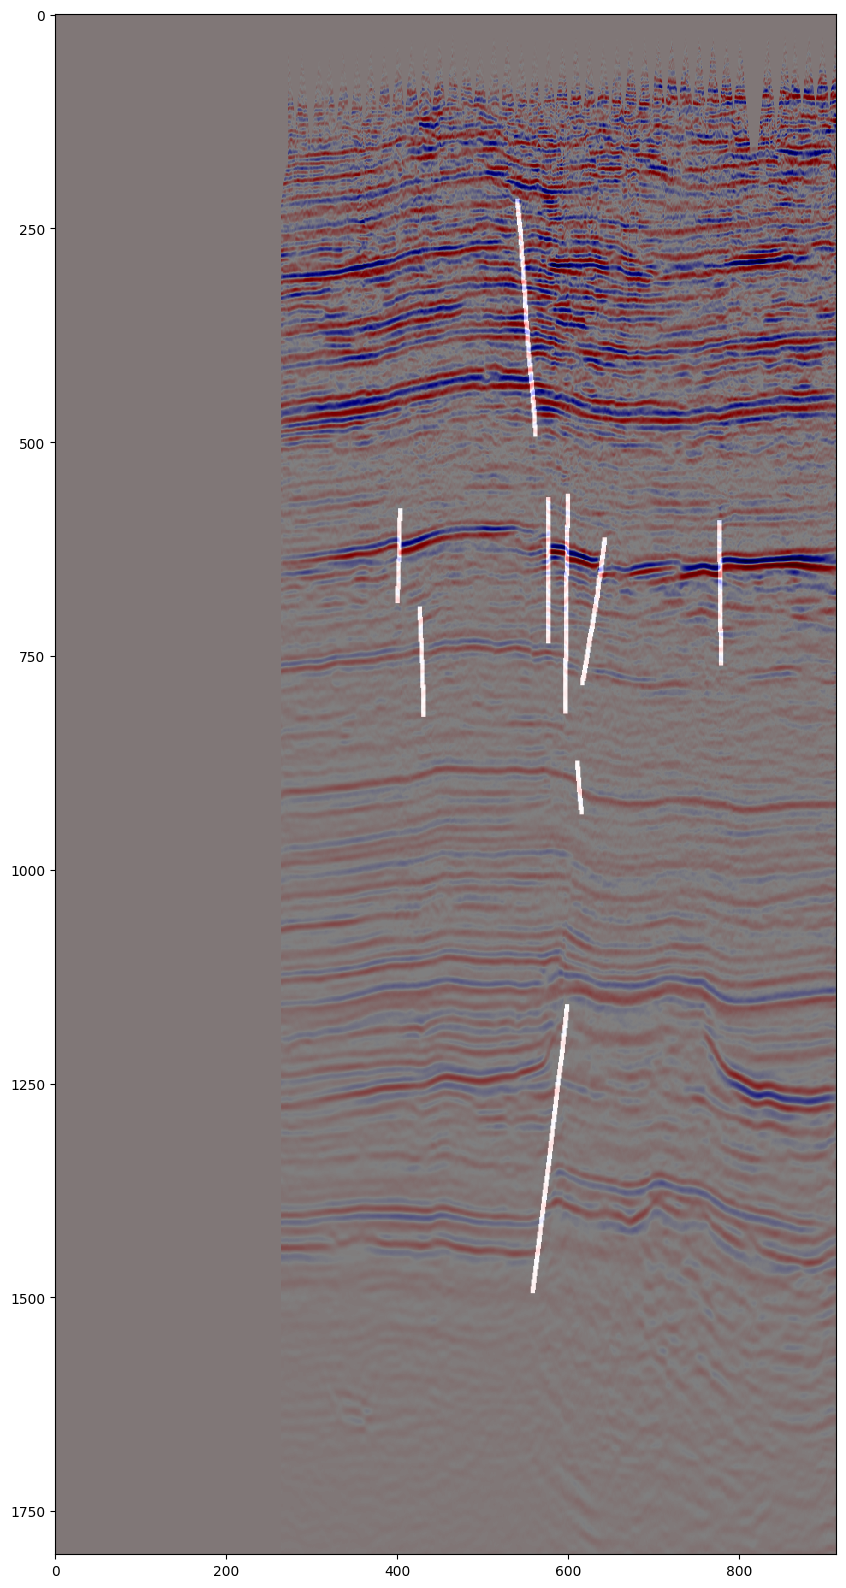

In [4]:
slice_num = 300
cube_slice = seismic_inlines[slice_num]
fault_slice = fault_inlines[slice_num]
plt.figure(figsize=(20,20))
plt.imshow(cube_slice, interpolation='nearest', cmap='seismic')
plt.imshow(fault_slice,  cmap='gray', alpha=0.5)

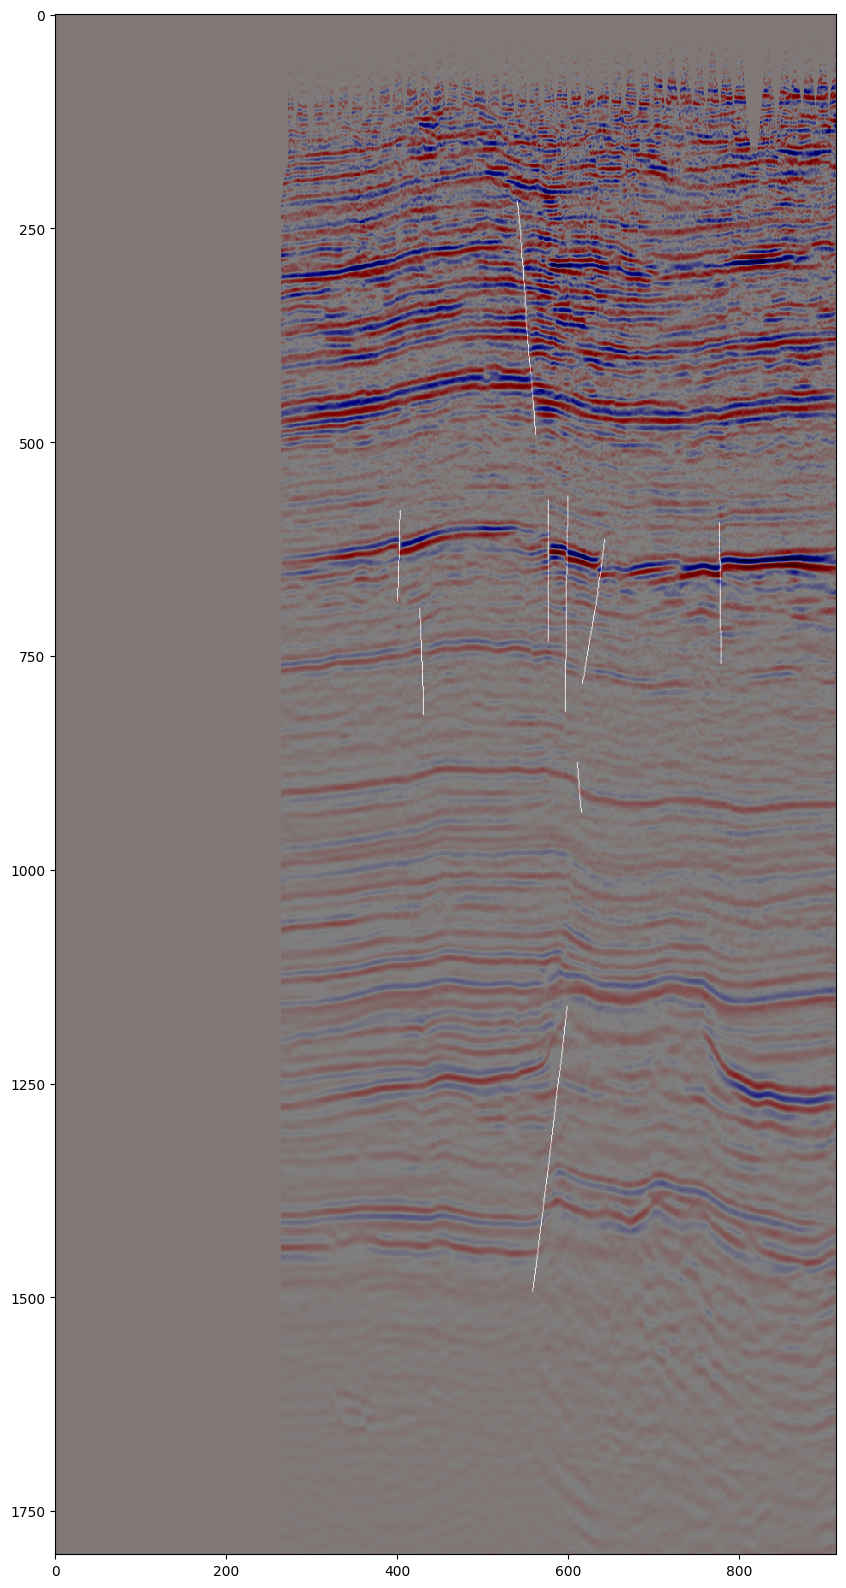

In [70]:
slice_num = 300
cube_slice = seismic_inlines[slice_num]
fault_slice = fault_inlines[slice_num]
plt.figure(figsize=(20,20))
plt.imshow(cube_slice, interpolation='nearest', cmap='seismic')
plt.imshow(fault_slice,  cmap='gray', alpha=0.5)

In [72]:
print(np.shape(seismic_inlines))
print(np.shape(fault_inlines))
print(np.dtype(fault_inlines[300,0,0]))

(648, 1801, 914)
(648, 1801, 914)
float64


464.0


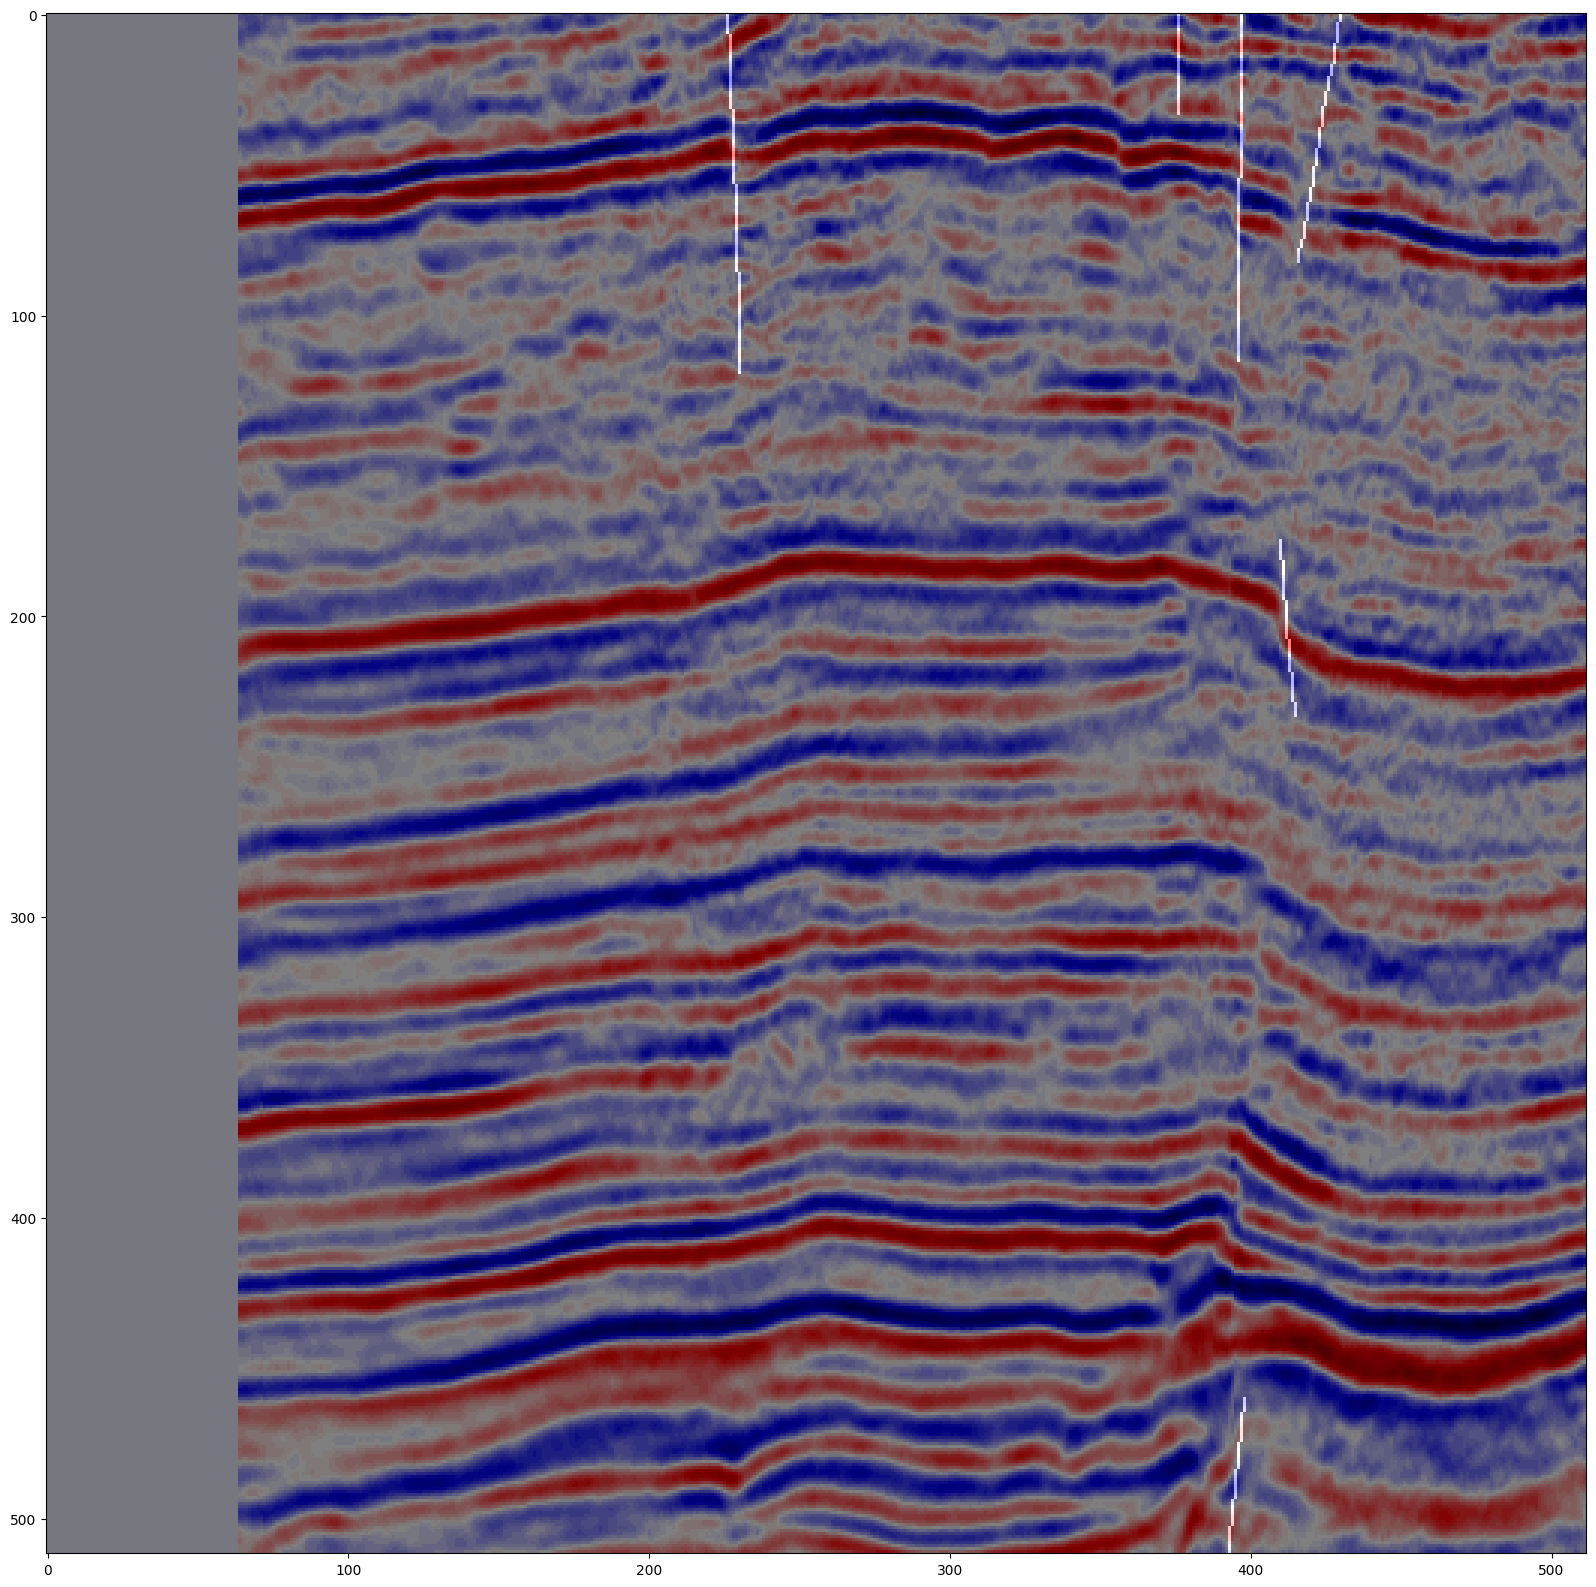

In [44]:
cube_window = cube.T[700:1212,200:712]
fault_window = res.T[700:1212,200:712]
plt.figure(figsize=(20,20))
plt.imshow(cube_window, interpolation='nearest', cmap='seismic')
plt.imshow(fault_window,  cmap='gray', alpha=0.5)
print(np.sum(fault_window))

In [27]:
print(type(data_cube))
print(type(res))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [73]:
print(np.min(seismic_inlines))
print(np.max(seismic_inlines))
print(np.min(fault_inlines))
print(np.max(fault_inlines))

-29701.291
27676.203
0.0
1.0


In [2]:
fault_inlines = np.load('data/raw/numpy/inline_faults.npz')['arr_0']
height = np.shape(fault_inlines[0])[0]
width = np.shape(fault_inlines[0])[1]
new_inlines = []
cnt = 0
for inline in fault_inlines:
    new_inline = np.copy(inline)
    for y in range(height):
        for x in range(width):
            if inline[y][x] != 0:
                if y != 0:
                    new_inline[y-1][x] = 1
                    if x != 0:
                        new_inline[y-1][x-1] = 1
                    if x != width - 1:
                        new_inline[y-1][x+1] = 1
                if x!= 0:
                    new_inline[y][x-1] = 1
                if x != width - 1:
                        new_inline[y][x+1] = 1
                if y != height -1:
                    new_inline[y+1][x] = 1
                    if x != 0:
                        new_inline[y+1][x-1] = 1
                    if x != width - 1:
                        new_inline[y+1][x+1] = 1
    new_inlines.append(new_inline)
    if cnt % 50 == 0:
        print(cnt)
    cnt += 1
new_inlines = np.array(new_inlines)
fault_inlines = None
np.savez_compressed('data/raw/numpy/inline_faults_thick', new_inlines)

0
50
100
150
200
250
300
350
400
450
500
550
600


In [2]:
fault_inlines = np.load('data/raw/numpy/inline_faults.npz')['arr_0']
height = np.shape(fault_inlines[0])[0]
width = np.shape(fault_inlines[0])[1]
new_inlines = []
radius = 3
cnt = 0
for inline in fault_inlines:
    new_inline = np.copy(inline)
    for y in range(height):
        for x in range(width):
            if inline[y][x] == 1:
                for y_shift in range(-radius, radius + 1):
                    for x_shift in range(-radius, radius + 1):
                        if (0 <= y + y_shift < height) and (0 <= x + x_shift < width):
                            new_inline[y+y_shift][x+x_shift] = 1
    new_inlines.append(new_inline)
    if cnt % 50 == 0:
        print(cnt)
    cnt += 1
new_inlines = np.array(new_inlines)
fault_inlines = None
np.savez_compressed('data/raw/numpy/inline_faults_thick_7', new_inlines)

0
50
100
150
200
250
300
350
400
450
500
550
600
